In [8]:
from parser import *
from config_parser import *
import re

# Получение списка товаров с помощью WB API

In [2]:
# Собираем 300 товаров (3 страницы)
# api_df = get_wb_products(query="мио стимулятор",pages=3) Для тестов 68 записей
api_df = get_wb_products(query="миостимулятор",pages=100)
api_df.to_csv("../data/wb_products.csv", index=False)
print(f"Собрано {len(api_df)} товаров")

Страница 1 получена
Страница 2 получена
Страница 3 получена
Страница 4 получена
Страница 5 получена
Страница 6 получена
Страница 7 получена
Страница 8 получена
Страница 9 получена
Страница 10 получена
Страница 11 получена
Страница 12 получена
Страница 13 получена
Страница 14 получена
Страница 15 получена
Страница 16 получена
Страница 17 получена
Страница 18 получена
Страница 19 получена
Страница 20 получена
Страница 21 получена
Страница 22 получена
Страница 23 получена
Страница 24 получена
Страница 25 получена
Страница 26 получена
Страница 27 получена
Страница 28 получена
Страница 29 получена
Страница 30 получена
Страница 31 получена
Страница 32 получена
Страница 33 получена
Страница 34 получена
Страница 35 получена
Страница 36 получена
Страница 37 получена
Страница 38 получена
Страница 39 получена
Страница 40 получена
Страница 41 получена
Страница 42 получена
Страница 43 получена
Страница 44 получена
Страница 45 получена
Страница 46 получена
Страница 47 получена
Страница 48 получена
С

# Фильтрация данных

In [3]:
api_df = pd.read_csv("../data/wb_products.csv")
api_df

,id,name,price,rating,feedbacks,brand
0,397455530,Массажер миостимулятор для тела пресса спины ш...,1278.0,4.7,71,eFlow
1,221329577,Миостимулятор 36 программ антицеллюлитный для ...,2052.0,4.9,1021,NaN
2,334678554,Миостимулятор 48 программ массажер для похудения,4196.0,4.9,1021,NaN
3,359420749,Миостимулятор для тела антицеллюлитный для пох...,1945.0,4.9,13,NaN
4,221352035,Миостимулятор 36 программ массажер для похудения,1847.0,4.9,1021,NaN
...,...,...,...,...,...,...
5995,384483737,Косметологический аппарат B-333,11551.0,0.0,0,NaN
5996,248314031,Массажер FH-320 цвета в ассортименте,1332.0,0.0,0,Isa
5997,237927173,Массажер для шеи и плеч KL-5830 микротоковый,1839.0,0.0,0,Neck Massager
5998,237927166,Массажер для шеи и плеч KL-5830,2016.0,0.0,0,Neck Massager


In [ ]:
# Первичный фильтр 

# Ключевые слова для ВКЛЮЧЕНИЯ
# include_keywords = [
#     r"\bмиостимулятор\b", r"\bэлектростимулятор\b", 
#     r"\bems\b", r"\bнейростимулятор\b", r"\bэлектронный стимулятор\b",
#     r"\bэлектрический стимулятор\b", r"\bимпульсный стимулятор\b",
#     r"\bмиостимуляция\b"
# ]

# Ключевые слова для ИСКЛЮЧЕНИЯ (аксессуары и нерелевантные категории)
# exclude_patterns = [
#     r"электрод", r"шнур", r"кабель", r"провод", 
#     r"пластин", r"насадк", r"гель", r"коврик", 
#     r"пульт", r"крепеж", r"держатель", r"запчасть",
#     r"аксессуар", r"электромассажер", r"вакуумный",
#     r"перкуссионный", r"вибромассажер", r"ручной",
#     r"сменные", r"аппликатор", r"бандаж", r"маска",
#     r"светодиодн", r"led", r"роликовый", r"массажер[^,]*$"
# ]

exclude_patterns = [
    r"электрод", r"шнур", r"кабель", r"провод", 
    r"пластин", r"гель",
    r"крепеж", r"держатель", r"запчасть",
    r"аксессуар", r"led"
]

# Фильтрация нерелевантных товаров
def is_relevant(name):
    if pd.isna(name):
        return False
        
    name = name.lower()
    
    if any(re.search(pattern, name) for pattern in exclude_patterns):
        return False
        
    # return any(re.search(kw, name) for kw in include_keywords)
    return True

mask = api_df['name'].apply(is_relevant)
clear_df = api_df[mask].copy()

# 1. Удалить товары без отзывов
clear_df = clear_df[clear_df['feedbacks'] > 0]

# 2. Рассчитать пороги для ценовых сегментов
price_25 = clear_df['price'].quantile(0.25)
price_75 = clear_df['price'].quantile(0.75)
feedback_median = clear_df['feedbacks'].median()

# 3. Отобрать топ-20% по отзывам?
top_20_percent = clear_df[clear_df['feedbacks'] >= clear_df['feedbacks'].quantile(0.8)]

# 4. Сбалансированные выборки по ценовым сегментам
low_price = clear_df[clear_df['price'] < price_25].nlargest(30, 'feedbacks')
mid_price = clear_df[(clear_df['price'] >= price_25) & (clear_df['price'] <= price_75)].nlargest(30, 'feedbacks')
high_price = clear_df[clear_df['price'] > price_75].nlargest(30, 'feedbacks')

# 5. Недооцененные товары с высоким рейтингом
undervalued = clear_df[
    (clear_df['rating'] >= 4.8) & 
    (clear_df['price'] < clear_df['price'].median()) & 
    (clear_df['feedbacks'] < feedback_median)
].nlargest(20, 'rating')

# Объединить все отобранные товары
final_ids = pd.concat([
    top_20_percent,
    low_price,
    mid_price,
    high_price,
    undervalued
])['id'].drop_duplicates()

clear_df = api_df[api_df["id"].isin(final_ids)]

clear_df.to_csv("../data/cleared_wb_products.csv")

In [84]:
clear_df["price"].describe()

count      357.000000
mean      2487.156863
std       3346.196735
min        141.000000
25%        680.000000
50%       1423.000000
75%       2867.000000
max      36023.000000
Name: price, dtype: float64

# Первичный анализ
## 1. Распределение цен

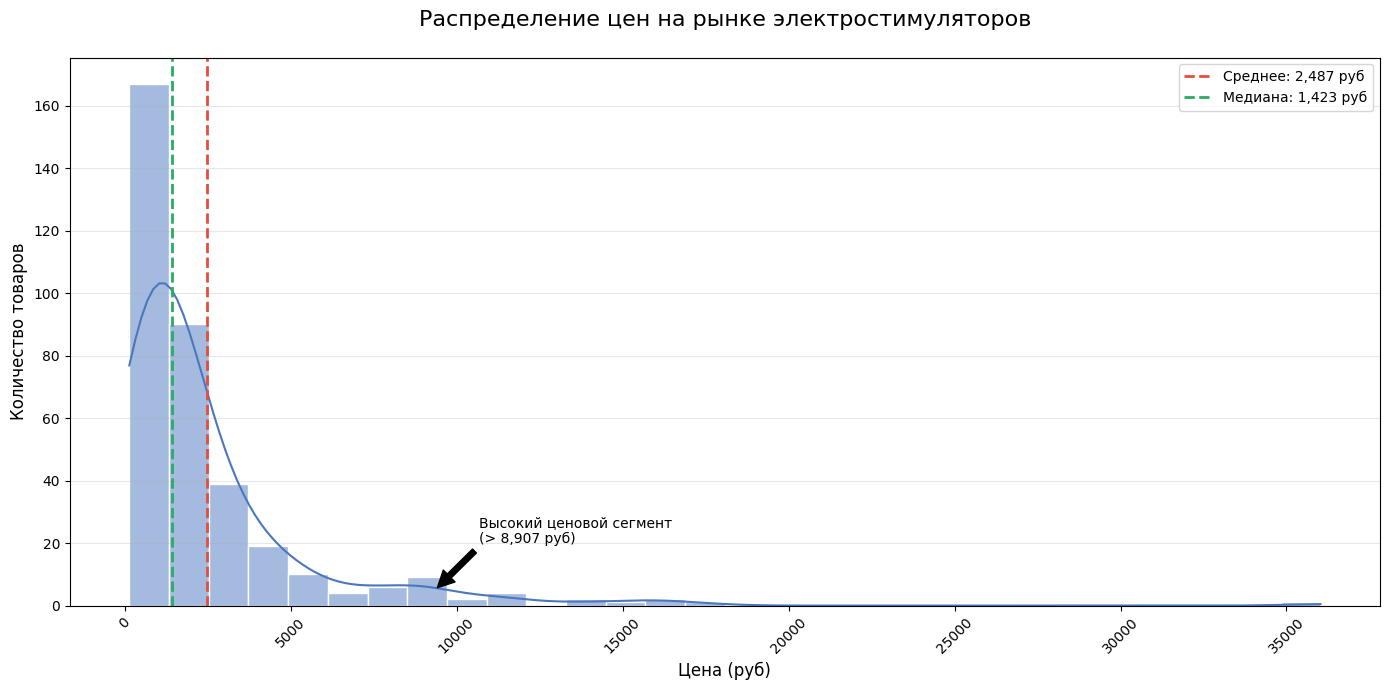

In [ ]:


import matplotlib.pyplot as plt
import seaborn as sns

price_data = clear_df["price"]

plt.figure(figsize=(14, 7))

ax = sns.histplot(price_data, bins=30, kde=True, 
                 color='#4B77BE', edgecolor='white')

mean_price = price_data.mean()
median_price = price_data.median()

plt.axvline(mean_price, color='#E74C3C', linestyle='--', 
           linewidth=2, label=f'Среднее: {mean_price:,.0f} руб')
plt.axvline(median_price, color='#27AE60', linestyle='--',
           linewidth=2, label=f'Медиана: {median_price:,.0f} руб')

q95 = price_data.quantile(0.95)
outliers = price_data[price_data > q95]
if len(outliers) > 0:
    plt.annotate(f'Высокий ценовой сегмент\n(> {q95:,.0f} руб)',
                xy=(q95*1.05, 5), xytext=(q95*1.2, 20),
                arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('Распределение цен на рынке электростимуляторов\n', fontsize=16)
plt.xlabel('Цена (руб)', fontsize=12)
plt.ylabel('Количество товаров', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Набольшая часть популярных товаров представлена в ценовом сегменте до 5000

## 2. Распределение цены без выбросов 

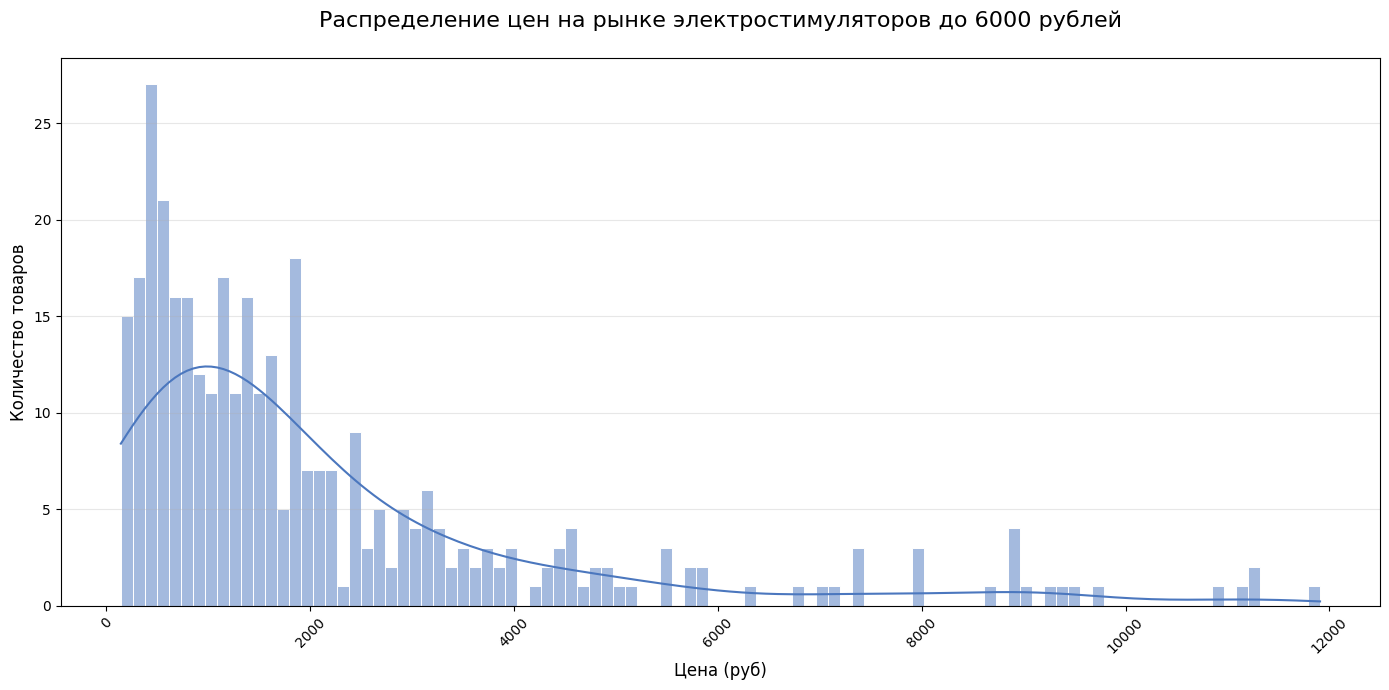

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

price_data = clear_df[clear_df["price"] <= clear_df["price"].mean() + 3 * clear_df["price"].std()]["price"]

plt.figure(figsize=(14, 7))
ax = sns.histplot(price_data, bins=100, kde=True,
                 color='#4B77BE', edgecolor='white')

mean_price = price_data.mean()
median_price = price_data.median()

plt.title('Распределение цен на рынке электростимуляторов до 6000 рублей\n', fontsize=16)
plt.xlabel('Цена (руб)', fontsize=12)
plt.ylabel('Количество товаров', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### Основные метрики

In [ ]:
stats = {
    'Средняя цена': f"{price_data.mean():,.0f} руб",
    'Медианная цена': f"{price_data.median():,.0f} руб",
    'Минимальная цена': f"{price_data.min():,.0f} руб",
    'Максимальная цена': f"{price_data.max():,.0f} руб",
    'Стандартное отклонение': f"{price_data.std():,.0f} руб",
    '95-й перцентиль': f"{price_data.quantile(0.95):,.0f} руб"
}

print("Ключевые метрики распределения цен:")
for k, v in stats.items():
    print(f"{k}: {v}")

Ключевые метрики распределения цен:
Средняя цена: 2,487 руб
Медианная цена: 1,423 руб
Минимальная цена: 141 руб
Максимальная цена: 36,023 руб
Стандартное отклонение: 3,346 руб
95-й перцентиль: 8,907 руб


## 3. Зависимость цены от рейтинга 

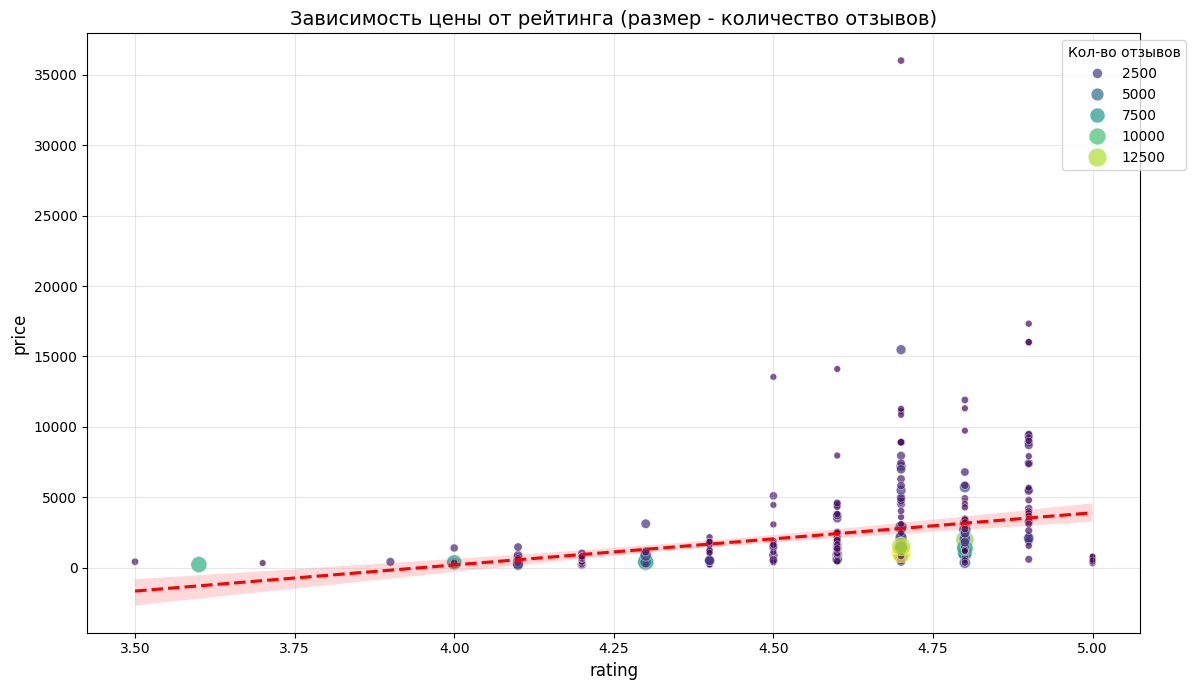

In [ ]:
# P.S. Обновить после подсчета отзывов по каждому конкретному товару

import numpy as np

plt.figure(figsize=(12, 7))
sns.scatterplot(data=clear_df, x='rating', y='price', 
                hue='feedbacks', size='feedbacks',
                sizes=(20, 200), alpha=0.7, palette='viridis')

plt.title('Зависимость цены от рейтинга (размер - количество отзывов)', fontsize=14)
plt.xlabel('Рейтинг', fontsize=12)
plt.ylabel('Цена (руб)', fontsize=12)
plt.xticks(np.arange(3.5, 5.1, 0.25))
plt.grid(alpha=0.3)
plt.ticklabel_format(style='plain', axis='y')

# Добавляем линию тренда
sns.regplot(data=clear_df, x='rating', y='price', 
           scatter=False, color='red', line_kws={'linestyle':'--'})

plt.legend(title='Кол-во отзывов', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

Электростимуляторы более дорогой ценовой категории получают рейтинг выше и пользуются большей популярностью

### Распределение цен в разных рейтинговых группах

/var/folders/x5/m9f65fq57_1642g0ls7c0zxw0000gn/T/ipykernel_16958/1485641326.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clear_df['rating_group'] = pd.cut(clear_df['rating'],
/var/folders/x5/m9f65fq57_1642g0ls7c0zxw0000gn/T/ipykernel_16958/1485641326.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=clear_df, x='rating_group', y='price',
/var/folders/x5/m9f65fq57_1642g0ls7c0zxw0000gn/T/ipykernel_16958/1485641326.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or 

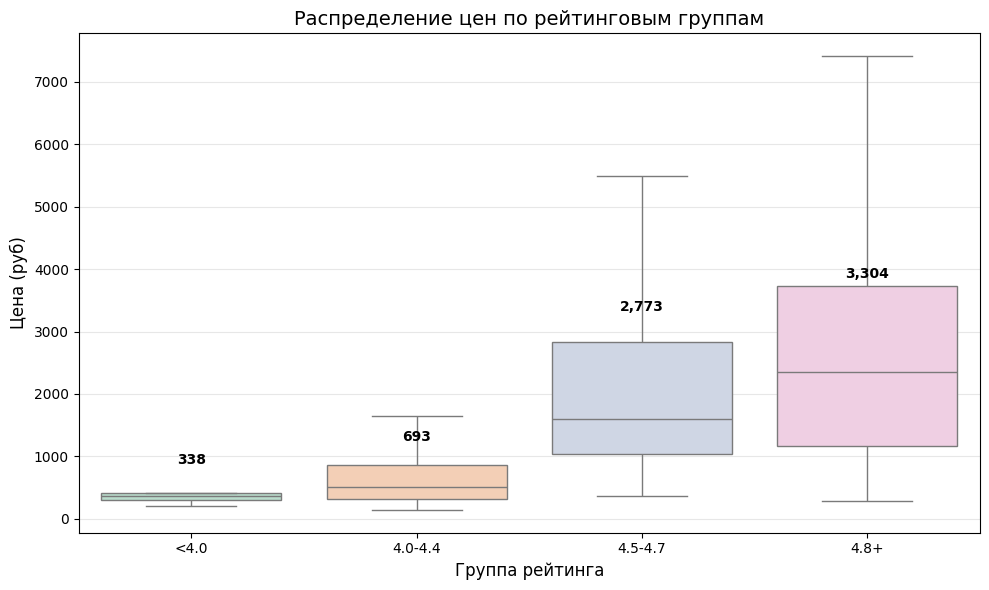

In [ ]:
#

plt.figure(figsize=(10, 6))

# Создаем рейтинговые группы
clear_df['rating_group'] = pd.cut(clear_df['rating'], 
                                   bins=[0, 3.9, 4.4, 4.7, 5],
                                   labels=['<4.0', '4.0-4.4', '4.5-4.7', '4.8+'])

sns.boxplot(data=clear_df, x='rating_group', y='price', 
           palette='Pastel2', showfliers=False)

plt.title('Распределение цен по рейтинговым группам', fontsize=14)
plt.xlabel('Группа рейтинга', fontsize=12)
plt.ylabel('Цена (руб)', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Добавляем средние значения
means = clear_df.groupby('rating_group')['price'].mean()
for i, mean in enumerate(means):
    plt.text(i, mean+500, f'{mean:,.0f}', 
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Ящик с усами цен по брендам

/var/folders/x5/m9f65fq57_1642g0ls7c0zxw0000gn/T/ipykernel_16958/3759864018.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['brand'] = boxplot_df['brand'].str.strip().str.title()
/var/folders/x5/m9f65fq57_1642g0ls7c0zxw0000gn/T/ipykernel_16958/3759864018.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


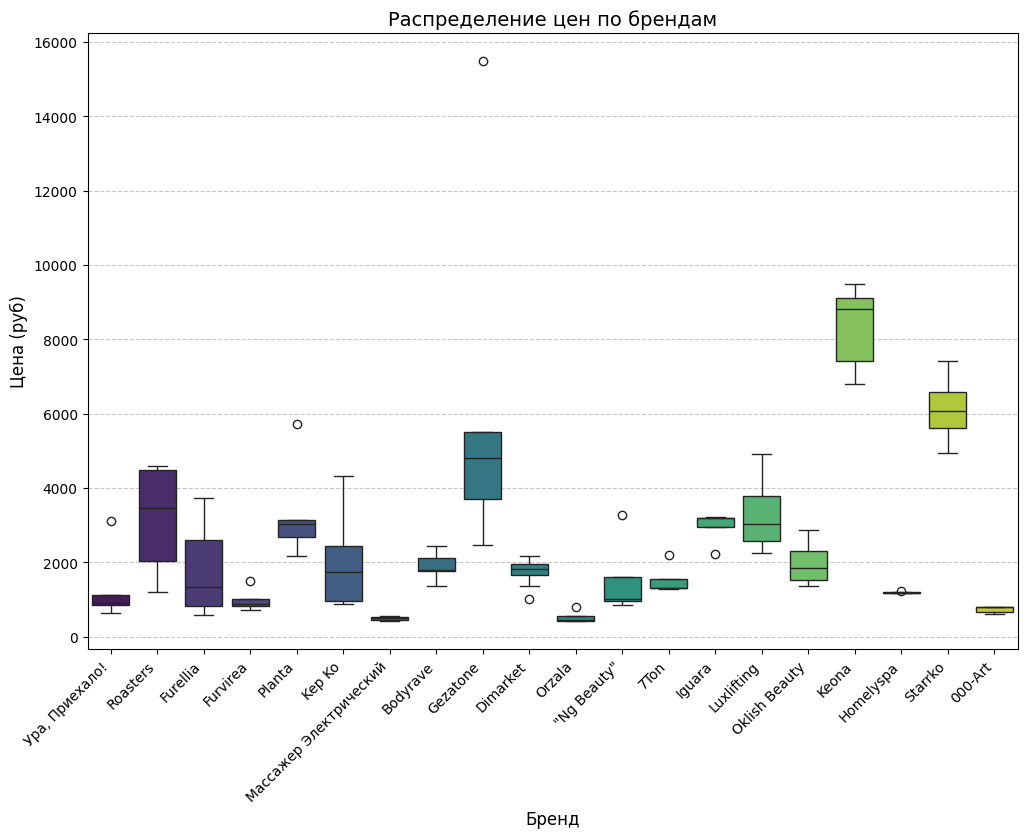

In [ ]:
# Boxplot по брендам

boxplot_df = clear_df.dropna(subset=["brand"])
boxplot_df['brand'] = boxplot_df['brand'].str.strip().str.title()

top_brands = boxplot_df['brand'].value_counts().head(20).index  # Топ-20 брендов
df_filtered = boxplot_df[boxplot_df['brand'].isin(top_brands)]

plt.figure(figsize=(12, 8))
sns.boxplot(
    data=df_filtered,
    x='brand',
    y='price',
    palette='viridis'
)
plt.title('Распределение цен по брендам', fontsize=14)
plt.xlabel('Бренд', fontsize=12)
plt.ylabel('Цена (руб)', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Поворот подписей
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [109]:
clear_df

,id,name,price,rating,feedbacks,brand,cluster,rating_group
1,221329577,Миостимулятор 36 программ антицеллюлитный для ...,2052.0,4.9,1021,NaN,0,4.8+
2,334678554,Миостимулятор 48 программ массажер для похудения,4196.0,4.9,1021,NaN,2,4.8+
4,221352035,Миостимулятор 36 программ массажер для похудения,1847.0,4.9,1021,NaN,0,4.8+
5,91028354,Миостимулятор массажер импульсный электрически...,2543.0,4.6,561,AShop,0,4.5-4.7
6,169351017,"Миостимулятор FZ-1 ""ШУБОШИ"" для мышц",3986.0,4.9,365,SHUBOSHI,2,4.8+
...,...,...,...,...,...,...,...,...
5757,354637348,Косметический микротоковый вибромассажер для лица,1359.0,4.6,600,Dimarket,0,4.5-4.7
5764,239568299,Подставка для микротокового аппарата массажера...,352.0,4.8,413,Kirei Tech,0,4.8+
5798,405657557,Микротоковый роликовый массажер роллер для лица,2459.0,4.7,217,NaN,0,4.5-4.7
5810,14568528,Массажёр для шеи ног спины плеч и тела,1500.0,4.7,12804,Массажер Showerli,0,4.5-4.7


In [113]:
driver = init_driver_firefox(headless=browser_headless)
# driver = init_driver_firefox()

In [115]:
# Первичный тест парсера
details = get_product_details(driver, 176410178)

Кнопка подтверждения возраста не найдена
Характеристики успешно открыты
Описание 1 не найдено
Описание успешно записано


In [ ]:
print(details)

In [116]:
final_main_df = pd.DataFrame(columns=['id', 'power_type', 'zones', 'description'])
final_specs_df = pd.DataFrame(columns=['good_id', 'group_name', 'name', 'value'])
curr_count = 0
total = len(clear_df)

for product_id in clear_df["id"]:
    try:
        curr_count += 1
        # Получаем данные товара (предполагаем, что функция get_product_details реализована)
        details = get_product_details(driver, product_id)
        
        # Парсим данные товара
        current_main_df, current_specs_df = parse_product_data(details, product_id)
        
        # Добавляем данные в итоговые DataFrame
        final_main_df = pd.concat([final_main_df, current_main_df], ignore_index=True)
        final_specs_df = pd.concat([final_specs_df, current_specs_df], ignore_index=True)

        print(f"Получение товара {product_id} выполнено; Осталось получить: {total - curr_count} ")
        delay = random.uniform(0.5, 1)
        time.sleep(delay)
        
    except Exception as e:
        print(f"==================================\nОшибка при обработке товара {product_id}: {str(e)}\n==================================")
        continue


Кнопка подтверждения возраста не найдена
Характеристики успешно открыты
Описание успешно записано
Получение товара 221329577 выполнено; Осталось получить: 356 
Кнопка подтверждения возраста не найдена
Характеристики успешно открыты
Описание успешно записано
Получение товара 334678554 выполнено; Осталось получить: 355 
Кнопка подтверждения возраста не найдена
Характеристики успешно открыты
Описание успешно записано
Получение товара 221352035 выполнено; Осталось получить: 354 
Кнопка подтверждения возраста не найдена
Характеристики успешно открыты
Описание успешно записано
Получение товара 91028354 выполнено; Осталось получить: 353 
Кнопка подтверждения возраста не найдена
Характеристики успешно открыты
Описание успешно записано
Получение товара 169351017 выполнено; Осталось получить: 352 
Кнопка подтверждения возраста не найдена
Характеристики успешно открыты
Описание успешно записано
Получение товара 251013688 выполнено; Осталось получить: 351 
Кнопка подтверждения возраста не найдена


In [117]:
merged_main_df = pd.merge(
    clear_df,
    final_main_df,
    left_on="id",
    right_on="id",
    how='right'
)
merged_main_df

,id,name,price,rating,feedbacks,brand,cluster,rating_group,power_type,zones,description
0,221329577,Миостимулятор 36 программ антицеллюлитный для ...,2052.0,4.9,1021,NaN,0,4.8+,USB; от аккумулятора,ноги; спина; тело,Импульсный массажер – это высокотехнологичный ...
1,334678554,Миостимулятор 48 программ массажер для похудения,4196.0,4.9,1021,NaN,2,4.8+,от аккумулятора,тело,Четырехканальное обезболивание: 4-канальный ст...
2,221352035,Миостимулятор 36 программ массажер для похудения,1847.0,4.9,1021,NaN,0,4.8+,от аккумулятора,тело,Импульсный массажер – это высокотехнологичный ...
3,91028354,Миостимулятор массажер импульсный электрически...,2543.0,4.6,561,AShop,0,4.5-4.7,220В (5А); 3 батарейки ААА; USB-шнур,ноги; пресс; тело,Миостимулятор импульсный массажер электрически...
4,169351017,"Миостимулятор FZ-1 ""ШУБОШИ"" для мышц",3986.0,4.9,365,SHUBOSHI,2,4.8+,от аккумулятора; от сети,Лицо / Тело / Руки / Ноги / Спина / Живот / Кожа,"Миостимулятор SHUBOSHI FZ-1 ""ШУБОШИ"" или ""Удоб..."
...,...,...,...,...,...,...,...,...,...,...,...
352,354637348,Косметический микротоковый вибромассажер для лица,1359.0,4.6,600,Dimarket,0,4.5-4.7,None,овал лица; подбородок; лицо,"Со временем кожа теряет свою эластичность, рас..."
353,239568299,Подставка для микротокового аппарата массажера...,352.0,4.8,413,Kirei Tech,0,4.8+,None,от морщин; для массажа лица; для кожи вокруг глаз,Подставка-зарядка для микротокового массажера ...
354,405657557,Микротоковый роликовый массажер роллер для лица,2459.0,4.7,217,NaN,0,4.5-4.7,None,лицо,Массажер для лица с технологией EMS (электриче...
355,14568528,Массажёр для шеи ног спины плеч и тела,1500.0,4.7,12804,Массажер Showerli,0,4.5-4.7,None,"лицо; для ног шеи тела спины лица; Спина, шея,...",Универсальный электрический роликовый массажер...


In [118]:
merged_main_df.to_csv("../data/details_cleared_wb_products.csv", index=False)

In [119]:
final_specs_df.to_csv("../data/other_specs_cleared_wb_products.csv", index=False)

In [120]:
final_specs_df

,good_id,group_name,name,value
0,221329577,Основная информация,Цвет,серебристый
1,221329577,Общие характеристики,Гарантийный срок,12 месяцев
2,221329577,Питание,Питание,USB; от аккумулятора
3,221329577,Технические особенности,Количество режимов работы,36 режимов
4,221329577,Насадки,Количество насадок,10 шт.
...,...,...,...,...
5843,229767312,Дополнительная информация,Страна производства,Китай
5844,229767312,Габариты,Вес с упаковкой (кг),0.8 кг
5845,229767312,Габариты,Длина упаковки,20 см
5846,229767312,Габариты,Высота упаковки,6 см


# Парсинг отзывов

In [48]:
# Парсинг отзывов
# https://www.wildberries.ru/catalog/291888914/feedbacks 

# Передаём драйвер как аргумент
import re

def get_product_feedbacks(driver, product_id):
    driver.get(f"https://www.wildberries.ru/catalog/{product_id}/feedbacks")

    # Ожидание загрузки основного контейнера с отзывами
    WebDriverWait(driver, 30).until(
        EC.presence_of_element_located((By.CLASS_NAME, "comments__list, .non-comments"))
    )
    
    try:
        no_feedback = driver.find_element(By.CLASS_NAME, ".non-comments")
        print(f"{product_id} - нет отзывов")
        return pd.DataFrame(columns=['product_id', 'rating', 'advantage', 'disadvantage', 'comment'])
    except:
        pass

    # Проверка и переключение на вкладку "Этот вариант" если доступна
    try:
        # Ожидаем появления переключателя вариантов
        WebDriverWait(driver, 5).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, ".product-feedbacks__tabs"))
        )
        
        # Ищем кнопку "Этот вариант"
        variant_button = driver.find_element(
            By.CSS_SELECTOR, "li.product-feedbacks__tab:nth-child(2) > button:nth-child(1)"
        )
        variant_button.click()
        time.sleep(1.5)
    except:
        # Если нет переключателя или кнопки, продолжаем как обычно
        print(f"{product_id} - не удалось найти кнопку \"Этот вариант\"")
        pass

    # Прокрутка страницы для загрузки ВСЕХ отзывов
    last_height = driver.execute_script("return document.body.scrollHeight")
    scroll_attempts = 0
    max_scroll_attempts = 100 # Максимум попыток прокрутки для защиты от бесконечного цикла

    while scroll_attempts < max_scroll_attempts:
        # Прокрутка вниз
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(1.5)  # Ожидание подгрузки контента
        
        # Проверка изменения высоты страницы
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height
        scroll_attempts += 1

    # Сбор всех отзывов
    feedback_items = driver.find_elements(By.CSS_SELECTOR, "li.comments__item.feedback")
    feedbacks_list = []

    for item in feedback_items:
        try:
            # Парсинг рейтинга
            rating_elem = item.find_element(By.CLASS_NAME, "feedback__rating")
            rating_class = rating_elem.get_attribute("class")
            rating = int(re.search(r'star(\d+)', rating_class).group(1))
        except:
            rating = None

        # Инициализация текстовых полей
        advantage = None
        disadvantage = None
        comment = None
        
        # Парсинг текста отзыва
        try:
            text_block = item.find_element(By.CSS_SELECTOR, ".feedback__text.j-feedback__text")
            
            # Обработка структурированных отзывов (с разделами)
            sections = text_block.find_elements(By.CLASS_NAME, "feedback__text--item")
            if sections:
                for section in sections:
                    text = section.text.strip()
                    if not text:
                        continue
                        
                    if "feedback__text--item-pro" in section.get_attribute("class"):
                        advantage = text
                    elif "feedback__text--item-con" in section.get_attribute("class"):
                        disadvantage = text
                    else:
                        comment = text
            # Обработка неструктурированных отзывов
            else:
                comment = text_block.text.strip()
        except:
            pass  # Если текста нет, оставляем поля пустыми

        feedbacks_list.append({
            'product_id': product_id,
            'rating': rating,
            'advantage': advantage,
            'disadvantage': disadvantage,
            'comment': comment
        })

    # Создание DataFrame
    feedbacks = pd.DataFrame(feedbacks_list)
    print(f"{product_id} Отзывы успешно собраны. Количество отзывов: {len(feedbacks)}")
    return feedbacks

In [50]:
feedback = get_product_feedbacks(driver, 143533250)

feedback

143533250 Отзывы успешно собраны. Количество отзывов: 844


,product_id,rating,advantage,disadvantage,comment
0,143533250,5,Достоинства:Всё понравилось,"Недостатки:Не выключается экран при зарядке, в...",Комментарий:Аппарат брала для похудения и тону...
1,143533250,5,"Достоинства:Зарядки хватает на долго, пользуем...",None,None
2,143533250,5,Достоинства:Отличный прибор,None,None
3,143533250,5,"Достоинства:Прибор отличный, каждый день с жен...",None,None
4,143533250,5,Достоинства:Всё отлично,None,None
...,...,...,...,...,...
839,143533250,5,None,None,Отлично работает хорошо
840,143533250,5,None,None,🔥🔥🔥 от усталости. Жена радуется как ребенок) Д...
841,143533250,5,None,None,Восторг! Спина ликует! Даже над коленками накл...
842,143533250,5,None,None,Все работает. Все чудесно. Мощный.


In [51]:
feedback.to_csv("feedback.csv")

In [122]:
driver.quit()  # Закрываем браузер только после всех запросов

# Тестыыыы

In [ ]:
main_specs_df, other_specs_df = parse_product_data(details, 176410178)

{'description': 'Электростимулятор чрескожный универсальный Нейродэнс ПКМ — это современный физиотерапевтический аппарат, который станет надежным помощником в восстановлении и поддержании здоровья. Он предназначен для применения в домашних условиях, предоставляя возможность получать эффективные физиотерапевтические процедуры без необходимости посещения медицинских учреждений.\n\nПрибор работает на основе технологии электростимуляции, что позволяет воздействовать на мышцы, улучшая кровообращение и облегчая болевые ощущения. Устройство может использоваться для различных целей: от снятия напряжения после трудного дня до реабилитации после травм. С ним вы сможете проводить высококачественные процедуры, направленные на восстановление функциональности мышц и суставов, а также на долголетие здоровья.\n\nУниверсальный электростимулятор обладает несколькими режимами работы, которые легко переключаются в зависимости от потребностей пользователя. Компактный размер и стильный дизайн устройства позволяют его удобно использовать как в домашних условиях, так и брать с собой в поездки. Медицинский прибор оснащен простым и интуитивно понятным управлением, что делает его доступным для всех возрастных категорий.\n\nБлагодаря высококачественным материалам и современным технологиям, этот физиотерапевтический аппарат обеспечивает надежность и долгий срок службы. Нейродэнс ПКМ идеально подходит для тех, кто заботится о своем здоровье и стремится к активной жизни.\n\nС этим электростимулятором вы можете легко осуществлять заботу о своем организме, не выходя из дома. Он станет надежным партнёром в процессе восстановления и улучшения самочувствия.', 
'specifications': 
{'Общие характеристики': {'Гарантийный срок': '1 год'}, 
'Питание': {'Питание': 'от батареек'}, 
'Технические особенности': {'Количество режимов работы': '24'}, 
'Материалы': {'Материал корпуса': 'пластик'}, 
'Дополнительная информация': {'Вид воздействия': 'ток низкой частоты на определённые зоны тела', 
'Область применения': 'для всего тела', 'Противопоказания': 'индивидуальная непереносимость; наличие имплантированного кардиостимулятора', 'Комплектация': 'батарейки АА (2шт.); инструкция по эксплуатации; электростимулятор', 'Страна производства': 'Россия'}, 
'Габариты': {'Высота предмета': '4.5 см', 'Ширина предмета': '5.5 см', 'Длина предмета': '14.5 см', 'Вес товара без упаковки (г)': '350 г', 'Вес товара с упаковкой (г)': '425 г', 'Длина упаковки': '24 см', 'Высота упаковки': '9 см', 'Ширина упаковки': '17 см'}, 
'Документы': {'Регистрационное удостоверение': 'РЗН 2019/9330'}, 
'Без названия': {'': ''}}, 
'power_type': 'от батареек'}

{'description': 'Мио стимулятор для шеи - ощущение комфорта и расслабления на грани нового уровня!Приветствую! Если ты ищешь идеальное средство для максимального расслабления и ухода за своим телом, то Массажер мио стимулятор для шеи - твой идеальный выбор! Позволь мне рассказать тебе, почему этот микротоковый миостимулятор стоит твоего внимания.Помимо уникального дизайна и компактных размеров, этот электрический миостимулятор специально разработан для эффективного массажа мышц шеи, спины и воротниковой зоны. Он использует микротоки, чтобы активировать мышцы, способствуя глубокому расслаблению и оздоровлению всего тела.Вот почему Массажер электростимулятор для шеи - это революционный аппарат для миостимуляции и электрического массажа:- Миостимуляция: Уникальная технология микротоков позволит тебе нежно стимулировать мышцы, обеспечивая непревзойденное чувство расслабления и снятия напряжения.- Легкий и компактный: Благодаря своему мини размеру, этот массажер станет твоим незаменимым спутником в путешествиях и повседневной жизни. Наслаждайся массажем в любое время и в любом месте!- Беспроводной: Этот электромиостимулятор оснащен батареей, поэтому нет необходимости использовать провода. Готов к использованию в любой момент!- Многофункциональный: Не только для шеи! Этот электромассажер также отлично подходит для использования на других зонах тела, таких как воротниковая зона, часть мышц спины. Обнаружь новые возможности для ухода за собой!- Оздоровление и косметический эффект: Благодаря электростимуляции мио стимулятор поможет усилить массажный эффект и улучшить общее состояние кожи. Получи не только расслабление, но и красоту!Если ты ищешь идеальный подарок для себя или для близкого человека, то Массажер Мио стимулятор для шеи - это идеальный выбор. Не упусти возможность насладиться максимальным расслаблением и оздоровительным эффектом, просто нажми на кнопку "Добавить в корзину" прямо сейчас!', 'specifications': {'Основная информация': {'Цвет': 'зеленый; черный'}, 'Общие характеристики': {'Количество предметов в упаковке': '1 шт.'}, 'Материалы': {'Материал изделия': 'пластик'}, 'Дополнительная информация': {'Зона массажа': 'шея; воротниковая зона', 'Действие': 'микротоки; импульсы; стимулирует кровообращение и улучшает питание тканей', 'Страна производства': 'Китай', 'Комплектация': 'массажер; usb-кабель'}, 'Габариты': {'Ширина предмета': '13 см', 'Высота предмета': '15 см', 'Вес товара с упаковкой (г)': '0.3 г', 'Длина упаковки': '19 см', 'Высота упаковки': '15 см', 'Ширина упаковки': '5 см'}}, 'power_type': None, 'zones': 'шея; воротниковая зона'}

In [ ]:

# https://basket-18.wbbasket.ru/vol2918/part291888/291888914/info/ru/card.json опицональный вариант парсинга инфы о товаре


In [63]:
# random.uniform(0.1, 3)

for i in range(100):
    print(random.uniform(0.5, 1.5))

0.5935708008896233
0.9528682536263479
0.7281459139371663
0.7212937024140541
1.3612180180114044
1.3343318902111054
0.9688114318942107
1.1060621233017311
0.9258313495331713
1.2549722835066326
1.0985746803036114
1.1769997141033617
0.6039166566408797
0.7452885978940176
0.9480435178253672
0.6385073295711176
0.6124980923165215
1.2322159356590725
0.7248834323040282
0.7749586224226347
1.2988430539220255
0.8912295555059521
0.6567131591982344
0.6477734007223448
1.1024019075743505
0.851992761472716
0.5772010905996738
0.5630929824044376
0.709656650910031
1.404011351241797
0.7297474271058513
1.2325315873842713
0.8538759285494836
1.410908781719846
0.5243524410581698
1.0509435501482942
1.2465779264823658
0.7062496901543402
0.6474919983043484
0.5286273365971108
1.1119429716332494
1.3349764356906395
1.2774549954365433
0.5191761150363726
1.3683097808987947
1.404062209868552
0.8598273662449979
0.829103321438213
0.6593733630287486
0.6575632010517043
1.0032455923588754
0.72941721687951
1.154264812182317
0.